In [ ]:
import pandas as pd

# 데이터 변환

## 오프라인 세일즈 데이터 -> 매장별 개폐업 일자 데이터로 변환 

In [97]:
import pandas as pd

# 데이터프레임 로드
offline_sales = pd.read_csv('../assets/data/offline_offline_wkly_Hazzys_sales.csv')

# 오프라인 스토어별 개장일(Open_Store_Week0)과 폐업일(Close_Store_Week0)을 추출하여 새로운 데이터프레임 생성
offline_store_info = offline_sales[['Off.Store.Code', 'Off.Store.Name2', 'Open_Store_Week0', 'Close_Store_Week0']]

# 중복 제거를 위해 고유한 매장 정보만 추출
offline_store_info = offline_store_info.drop_duplicates()

offline_store_info.head()

,Off.Store.Code,Off.Store.Name2,Open_Store_Week0,Close_Store_Week0
0,D223,현대무역닥스골프,200701.0,202112.0
48,D230,현대무역헤지스남성,200701.0,NaN
50,D253,현대중동닥스골프,200701.0,202233.0
141,D265,신세계강남닥스골프,200701.0,202252.0
175,D275,신세계본점닥스골프,200701.0,202208.0


### 전처리
온라인 데이터는 2019년부터 존재하므로 2019년 이전에 Open된 Store Row를 삭제

In [99]:
offline_store_info = offline_store_info.loc[offline_store_info['Open_Store_Week0'] >= 201901.0]
offline_store_info.sort_values(by='Open_Store_Week0', ascending=True, inplace=True)
offline_store_info

,Off.Store.Code,Off.Store.Name2,Open_Store_Week0,Close_Store_Week0
29434,H801,롯데인천터미널헤지스골프[폐점],201901.0,202117.0
29929,H837,천안쌍용점 헤지스골프,201901.0,202043.0
29763,H826,포천송우점 헤지스골프,201901.0,202038.0
30528,H948,시흥신천 헤지스골프,201901.0,NaN
30325,H882,충주헤지스골프,201901.0,202046.0
...,...,...,...,...
121954,J659,AK평택헤지스ACC,202325.0,NaN
121983,J685,헤지스ACC영업_디즈니특판수탁_현대판교,202335.0,202335.0
36597,J733,현대가든파이브헤지스/질ACC복합,202336.0,NaN
81032,J770,스타필드안성 헤지스종합,202346.0,NaN


## 온라인 세일즈 데이터 -> 주차별 매출 데이터로 변환

In [88]:
online_Wkly_HZ = pd.read_csv('../assets/data/online_Wkly.HZ.csv')
online_Wkly_HY = pd.read_csv('../assets/data/online_Wkly.HY.csv')
online_Wkly_HS = pd.read_csv('../assets/data/online_Wkly.HS.csv')
online_Wkly_HG = pd.read_csv('../assets/data/online_Wkly.HG.csv')

# 데이터프레임을 행 단위로 병합 (index를 무시하고 행을 수평적으로 결합)
online_sales_info = pd.concat([online_Wkly_HZ, online_Wkly_HY, online_Wkly_HS, online_Wkly_HG], ignore_index=True)

# Wk_Year별로 Sales.Actual의 합산을 구하여 온라인 매출 시계열 데이터 생성
online_sales_by_year = online_sales_info.groupby('Wk_Year')['Sales.Actual'].sum().reset_index()

online_sales_by_year.head()

,Wk_Year,Sales.Actual
0,201901,574998.045636
1,201902,317057.004691
2,201903,281392.741391
3,201904,331473.422855
4,201905,253395.597155


In [90]:
online_sales_by_year['Wk_Year'].value_counts()

Wk_Year
202352    1
201901    1
201902    1
201903    1
201904    1
         ..
201910    1
201909    1
201908    1
201907    1
201906    1
Name: count, Length: 261, dtype: int64

# ARIMA 분석

## ACF, PACF 확인


ADF Statistic: -6.071881783589787
p-value: 1.145648573844328e-07


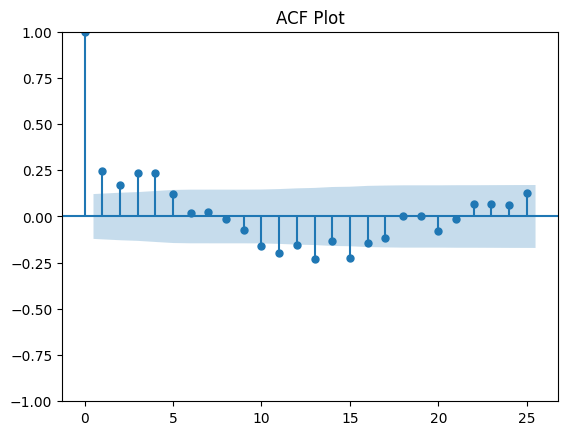

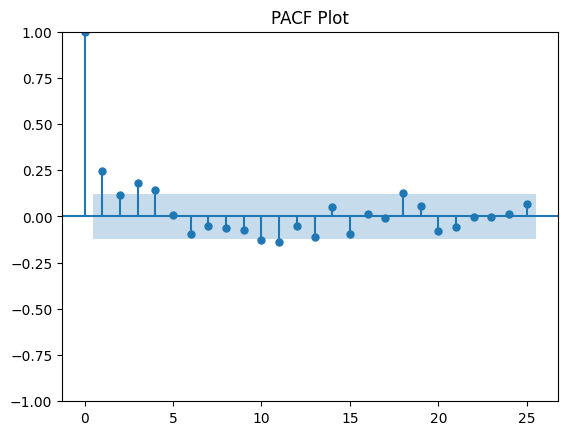

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

# 경고 메시지 무시
warnings.filterwarnings("ignore")

# 데이터 전처리
# 개업 및 폐업 이벤트 더미 변수 생성
events = pd.DataFrame({
    'Wk_Year': [],
    'New_Store': [],
    'Closed_Store': []
})

# 개업 이벤트
for index, row in offline_store_info.iterrows():
    open_week = int(row['Open_Store_Week0'])
    closed_week = int(row['Close_Store_Week0']) if not pd.isna(row['Close_Store_Week0']) else None
    
    # 개업 주차에 이벤트 추가
    events = pd.concat([events, pd.DataFrame({'Wk_Year': [open_week], 'New_Store': [1], 'Closed_Store': [0]})], ignore_index=True)
    
    # 폐업 주차에 이벤트 추가 (존재할 경우)
    if closed_week:
        events = pd.concat([events, pd.DataFrame({'Wk_Year': [closed_week], 'New_Store': [0], 'Closed_Store': [1]})], ignore_index=True)

# 모든 이벤트 데이터프레임과 온라인 매출 데이터프레임 병합
events['Wk_Year'] = events['Wk_Year'].astype(int)
merged_data = pd.merge(online_sales_by_year, events.groupby('Wk_Year').sum().reset_index(), on='Wk_Year', how='outer').fillna(0)

# 시계열 데이터(DateTime)로 변환
merged_data['Wk_Year'] = pd.to_datetime(merged_data['Wk_Year'].astype(str) + '0', format='%Y%W%w')
merged_data.set_index('Wk_Year', inplace=True)

# ADF 테스트로 정상성 확인
result = adfuller(merged_data['Sales.Actual'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# ACF 및 PACF 플롯
plot_acf(merged_data['Sales.Actual'])
plt.title('ACF Plot')
plt.show()

plot_pacf(merged_data['Sales.Actual'])
plt.title('PACF Plot')
plt.show()

In [102]:
# 시계열 데이터 확인
## merged_data = 오프라인 개폐업 event와 온라인 세일즈의 병합 데이터프레임

merged_data

,Sales.Actual,New_Store,Closed_Store
Wk_Year,,,
2019-01-13,574998.045636,41.0,0.0
2019-01-20,317057.004691,1.0,0.0
2019-01-27,281392.741391,0.0,0.0
2019-02-03,331473.422855,2.0,0.0
2019-02-10,253395.597155,1.0,0.0
...,...,...,...
2023-12-03,322909.001909,0.0,2.0
2023-12-10,298765.105255,1.0,0.0
2023-12-17,312270.775273,0.0,1.0


## 정상성 확인 (ADF 테스트)

신뢰수준 95% 하에서, 데이터 정상성이 확인됨 (유의확률이 0.05 이하)

In [108]:
result = adfuller(merged_data['Sales.Actual'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -6.071881783589787
p-value: 1.145648573844328e-07


## ARIMA 모형 사용하기

[ARIMA 모형을 사용한 이유입니다.]
- 비정상 시계열 데이터의 처리: ARIMA는 비정상성을 제거하기 위해 차분(differencing) 과정을 포함하므로, 추세(Trend)나 변동성이 존재하는 시계열 데이터에 적합합니다. 이는 AR이나 MA, ARMA 모델이 정상성 가정을 전제로 하기 때문에 비정상성을 갖는 데이터를 제대로 처리하지 못하는 한계를 보완합니다.

  - 현재 데이터에서는 정상성이 확인되나, 코드의 확장성을 위해 새로운 데이터가 들어왔을 때 이 데이터가 비정상성을 보이는 CASE를 고려했습니다.

- 복잡한 데이터 패턴 포착: ARIMA는 자기회귀(AR)와 이동평균(MA) 요소를 결합하여 시계열의 복잡한 패턴을 포착할 수 있습니다. 또한, 차분을 통해 시간 의존성과 추세적 변동까지 모델링할 수 있어 비정상 시계열 데이터의 예측에 강점이 있습니다.

- 예측의 정확성: ARIMA는 AR, MA, ARMA 모델에 비해 단기 예측 성능이 우수하며, 시계열 데이터의 추세와 계절성을 효과적으로 반영할 수 있어 더 정확한 예측 결과를 제공합니다.


                               SARIMAX Results                                
Dep. Variable:           Sales.Actual   No. Observations:                  261
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -3459.150
Date:                Wed, 09 Oct 2024   AIC                           6928.300
Time:                        22:39:57   BIC                           6946.123
Sample:                             0   HQIC                          6935.464
                                - 261                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
New_Store     2.629e+04   1223.107     21.493      0.000    2.39e+04    2.87e+04
Closed_Store  1.928e+05   8163.629     23.613      0.000    1.77e+05    2.09e+05
ar.L1            0.9885      0.007    146.40

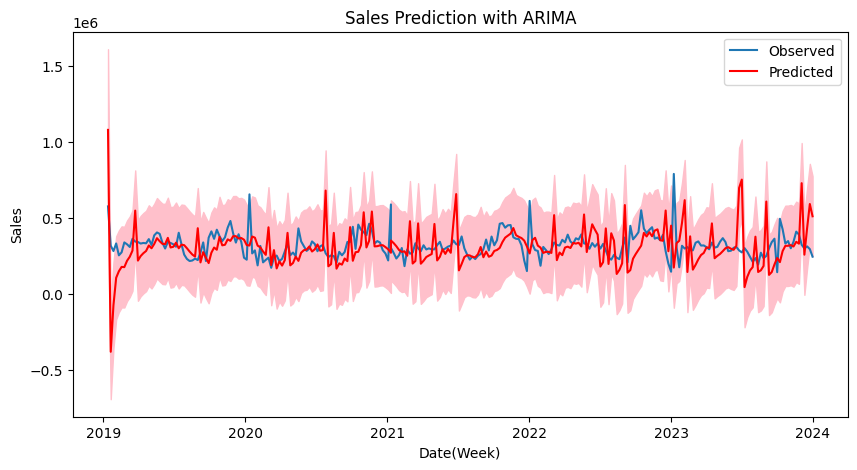

In [111]:
# ARIMA 모델 적합
# p, d, q 값은 ACF와 PACF 플롯을 보고 결정합니다.
model = SARIMAX(merged_data['Sales.Actual'], 
                exog=merged_data[['New_Store', 'Closed_Store']], 
                order=(1, 0, 1), 
                seasonal_order=(0, 0, 0, 0))

results = model.fit()

# 결과 요약
print(results.summary())

# 예측 수행
# 예측을 시작할 날짜를 데이터프레임의 인덱스 중 하나로 설정
start_date = merged_data.index[0]  # 첫 번째 날짜로 설정
pred = results.get_prediction(start=start_date, dynamic=False)
pred_conf = pred.conf_int()

# 예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(merged_data['Sales.Actual'], label='Observed')
plt.plot(pred.predicted_mean, label='Predicted', color='r')
plt.fill_between(pred_conf.index, 
                 pred_conf.iloc[:, 0], 
                 pred_conf.iloc[:, 1], color='pink')
plt.title('Sales Prediction with ARIMA')
plt.xlabel('Date(Week)')
plt.ylabel('Sales')
plt.legend()
plt.show()


# 결론
"New_Store, Closed_Store 이벤트가 온라인 세일즈 데이터에 유의미한 영향을 미치지 않는다"라는 귀무가설이
유의확률이 0.01 이하이므로, 신뢰구간 99%에서 귀무가설을 기각한다.

즉, 오프라인의 개폐업 이벤트는 온라인 세일즈(매출) 데이터에 유의미한 영향을 미친다.